In [1]:
import pandas as pd
import numpy as np
   
from sklearn.linear_model import LinearRegression,Ridge, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error,make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import lightgbm
from lightgbm import LGBMRegressor


import warnings
warnings.simplefilter('ignore')

In [2]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

# setting some globl config
plt.style.use('ggplot')
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.options.display.max_colwidth = 200

# 1. Read data

In [5]:
df = pd.read_excel('MMM_Store sales.xlsx')

In [6]:
# Remove ($) in column names; lower case column names
df.rename(columns=lambda x: x.replace(' ($)','').replace(" ", "_").lower(), inplace=True)

# Drop 'month' column
df.drop(columns=['month'],inplace=True)

In [7]:
df.head()

in_store_advertising  billboard_advertising  print_advertising  satisfaction  competitor_adversiting  price      sales
0                  1698                    698                556            68                     607     95 13605.6119
1                  2069                   1075                775            72                     637    101 19142.6733
2                  2271                    615                772            71                     761     95 15027.6234
3                  1413                   1158               1098            79                    1183     98 16589.6591
4                  2107                   1175                386            77                     940     97 21887.5821

# 2. EDA

## 2.1 Check missing values

In [8]:
# Check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   in_store_advertising    1000 non-null   int64  
 1   billboard_advertising   1000 non-null   int64  
 2   print_advertising       1000 non-null   int64  
 3   satisfaction            1000 non-null   int64  
 4   competitor_adversiting  1000 non-null   int64  
 5   price                   1000 non-null   int64  
 6   sales                   1000 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 54.8 KB


## 2.2 Check 'sales' distribution

In [9]:
df['sales'].describe()

count    1000.0000
mean    17585.5701
std      3675.8224
min      5819.2585
25%     15061.5302
50%     17385.3589
75%     20038.3049
max     33766.6915
Name: sales, dtype: float64

In [10]:
#histogram
#sns.histplot(df['sales'],kde=True, stat="density")
#plt.show()

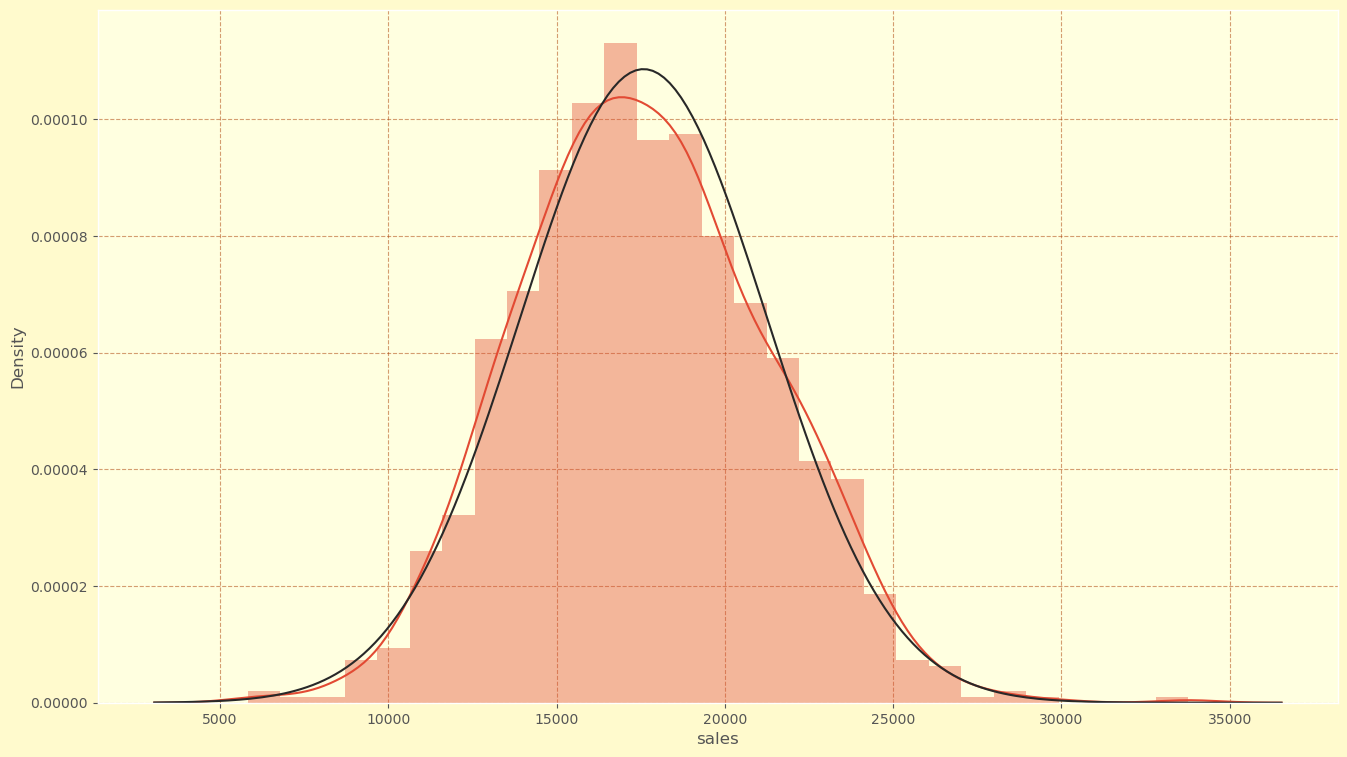

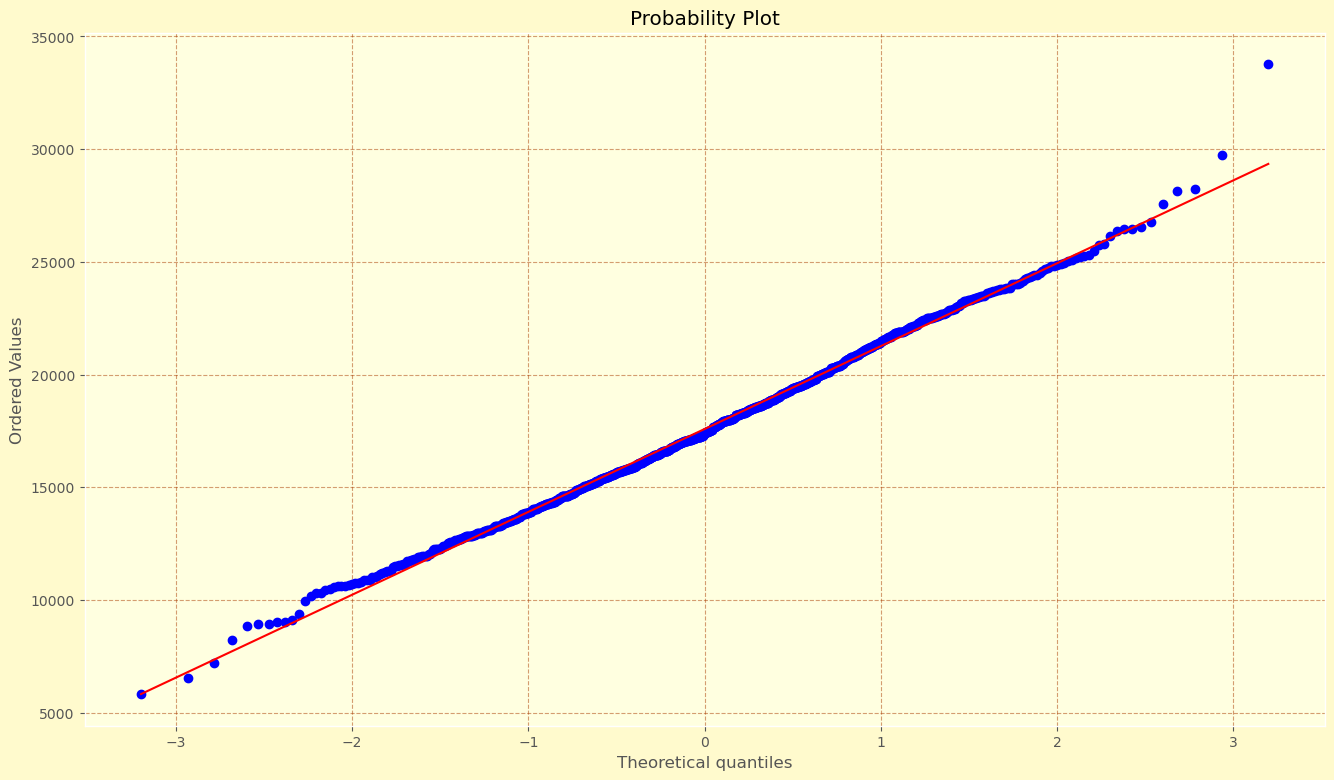

In [11]:
sns.distplot(df['sales'], fit=norm)
plt.show()
res = stats.probplot(df['sales'], plot=plt)

In [12]:
#skewness and kurtosis
print(f"Skewness of 'sales': {df['sales'].skew():.6f}")
print(f"Kurtosis of 'sales': {df['sales'].kurt():.6f}")

Skewness of 'sales': 0.172684
Kurtosis of 'sales': 0.104839


**Insights: The distribution of 'sales' is close to normal distribution**

## 2.3 Relationship between 'sales' and other features

In [13]:
features = ['in_store_advertising', 'billboard_advertising', 'print_advertising',
            'satisfaction', 'competitor_adversiting', 'price']

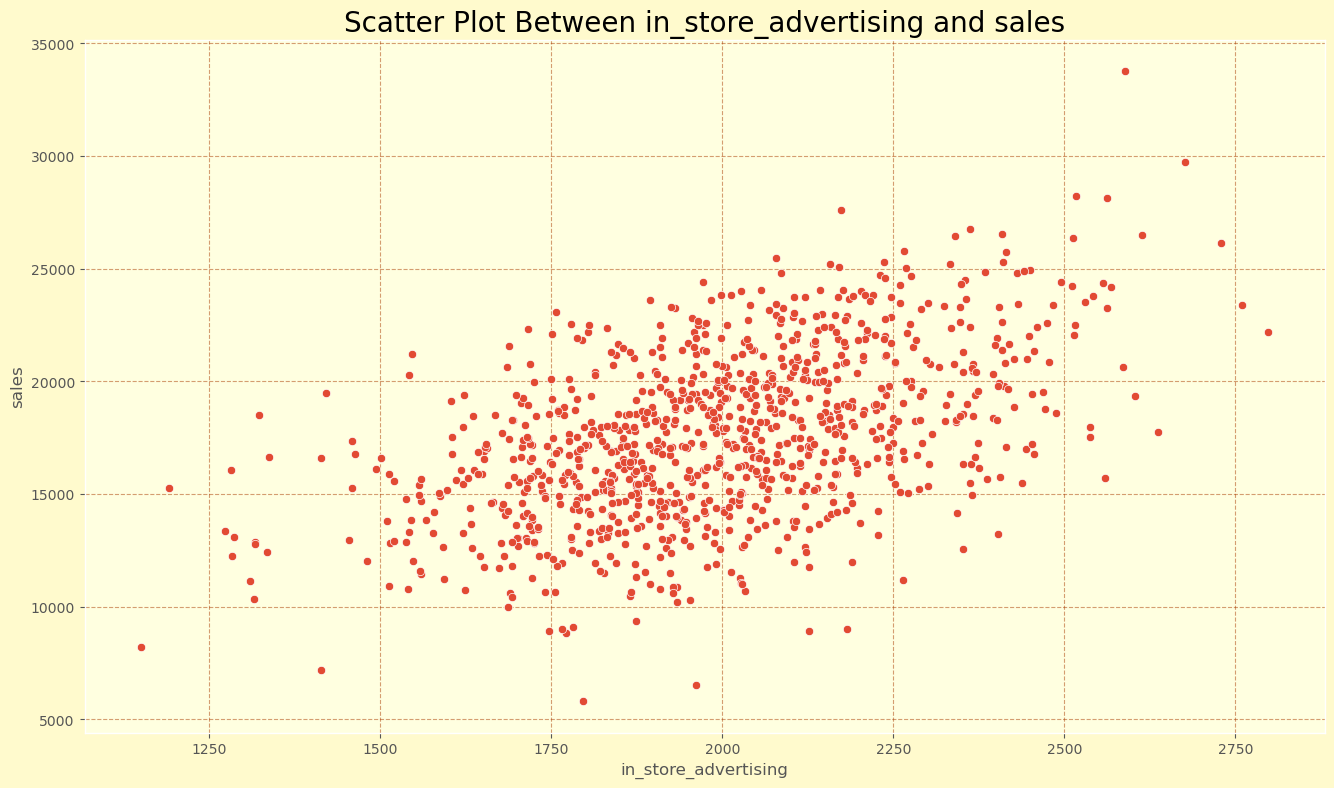

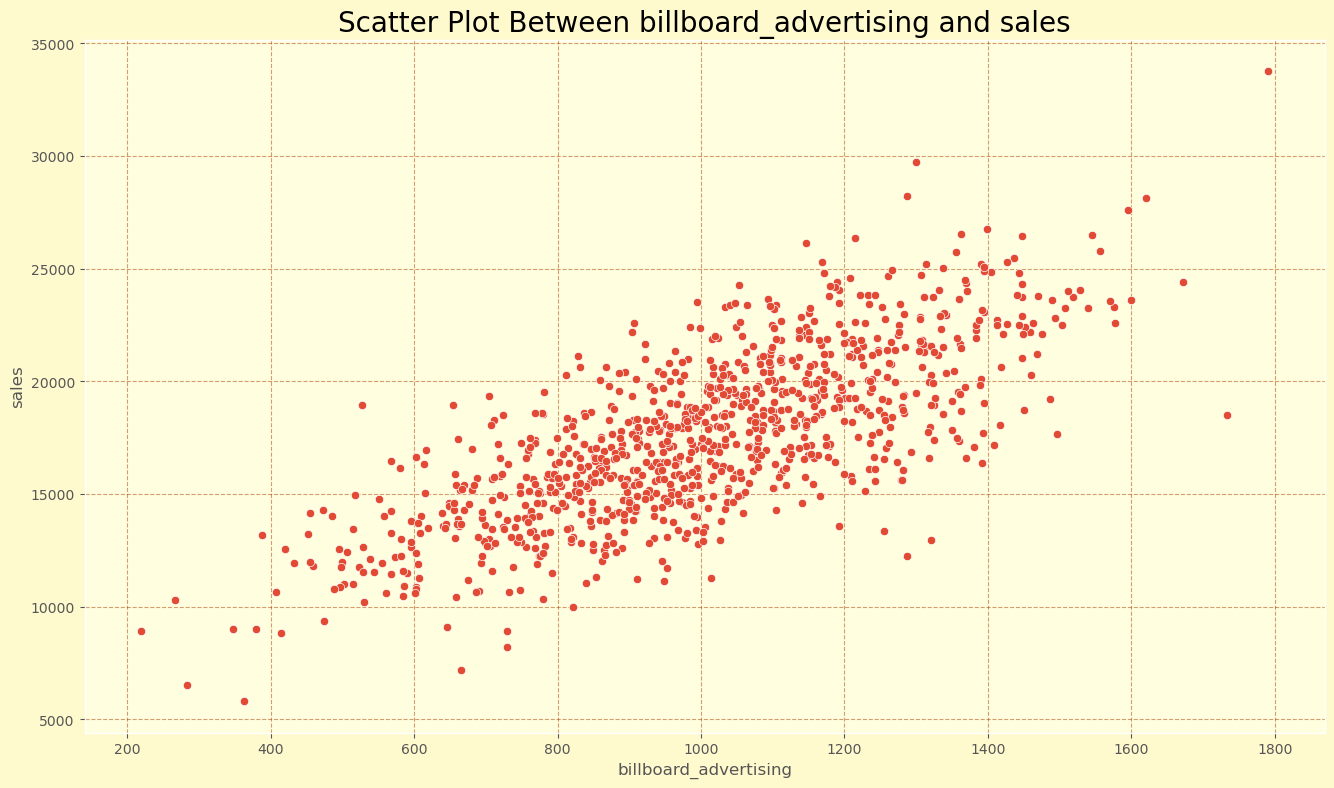

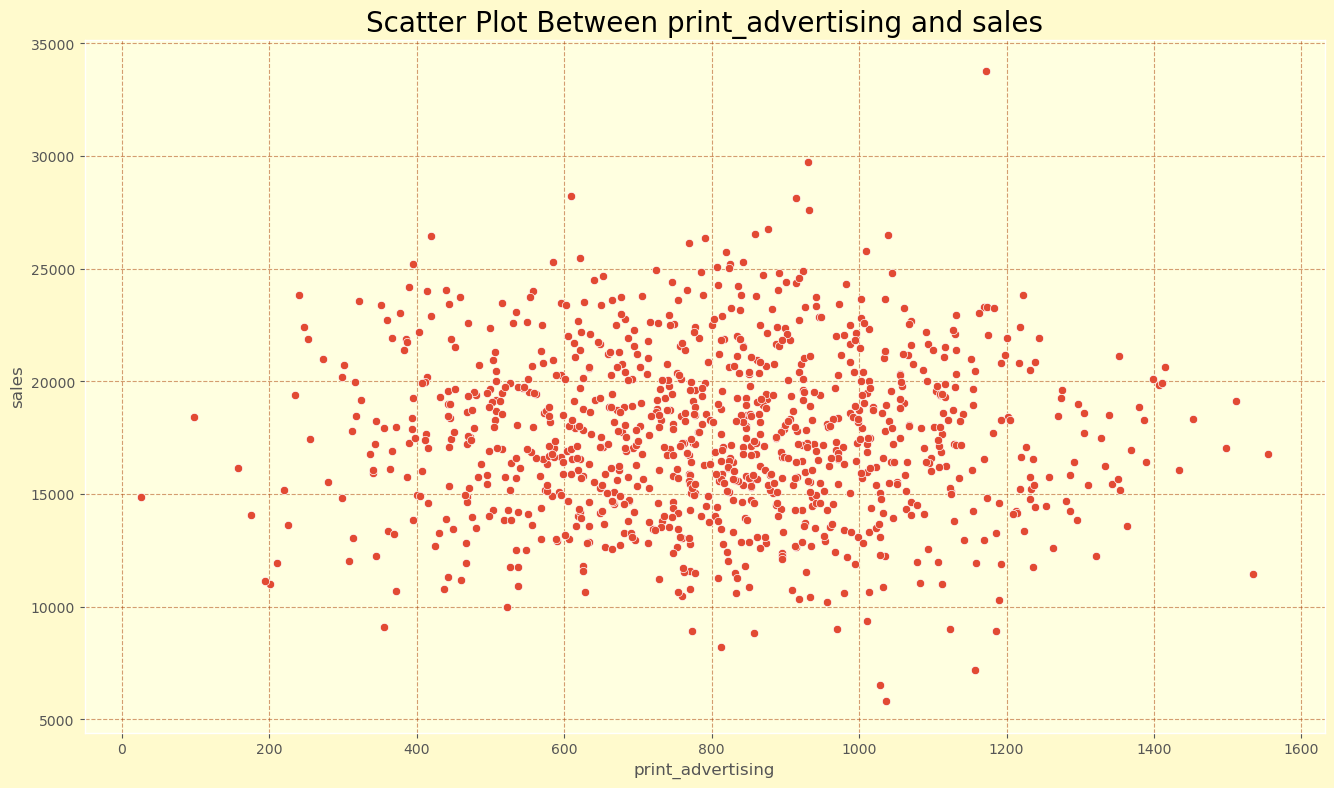

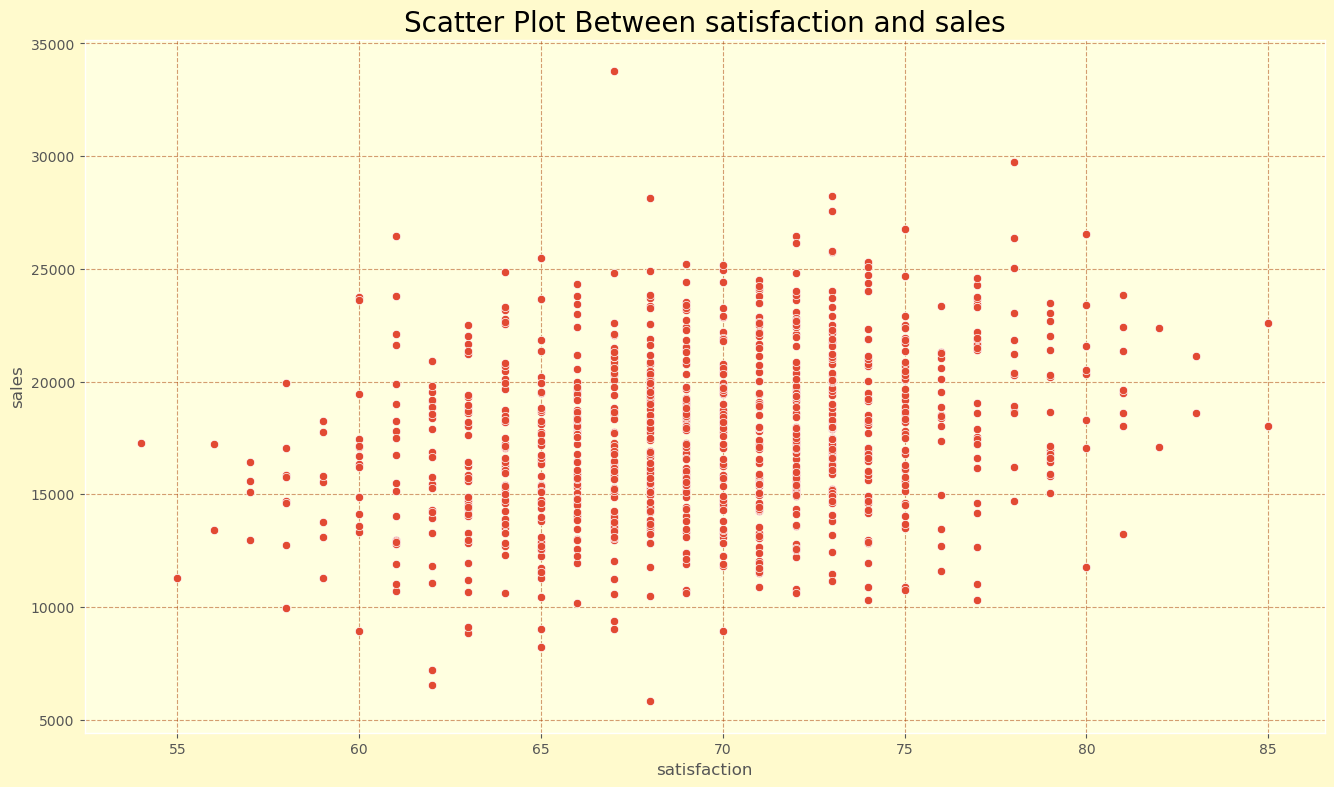

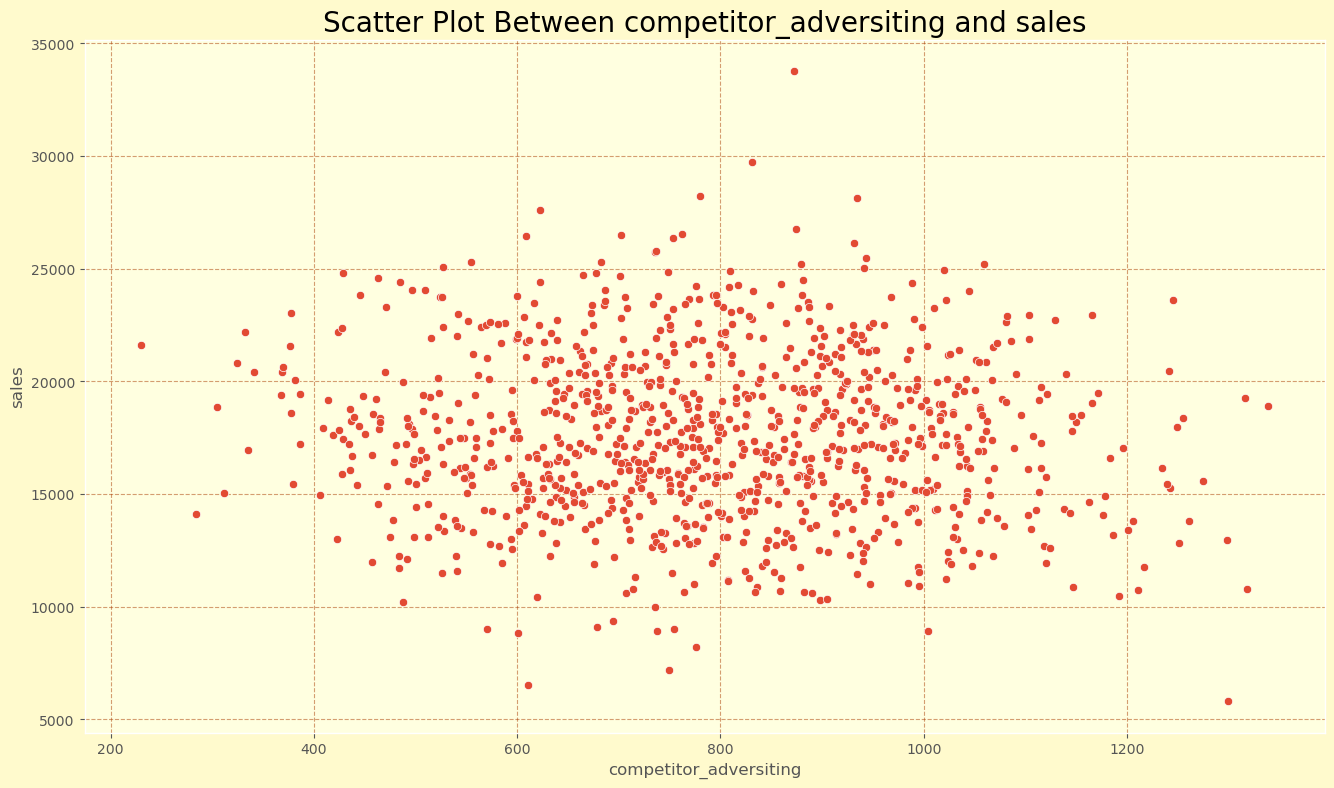

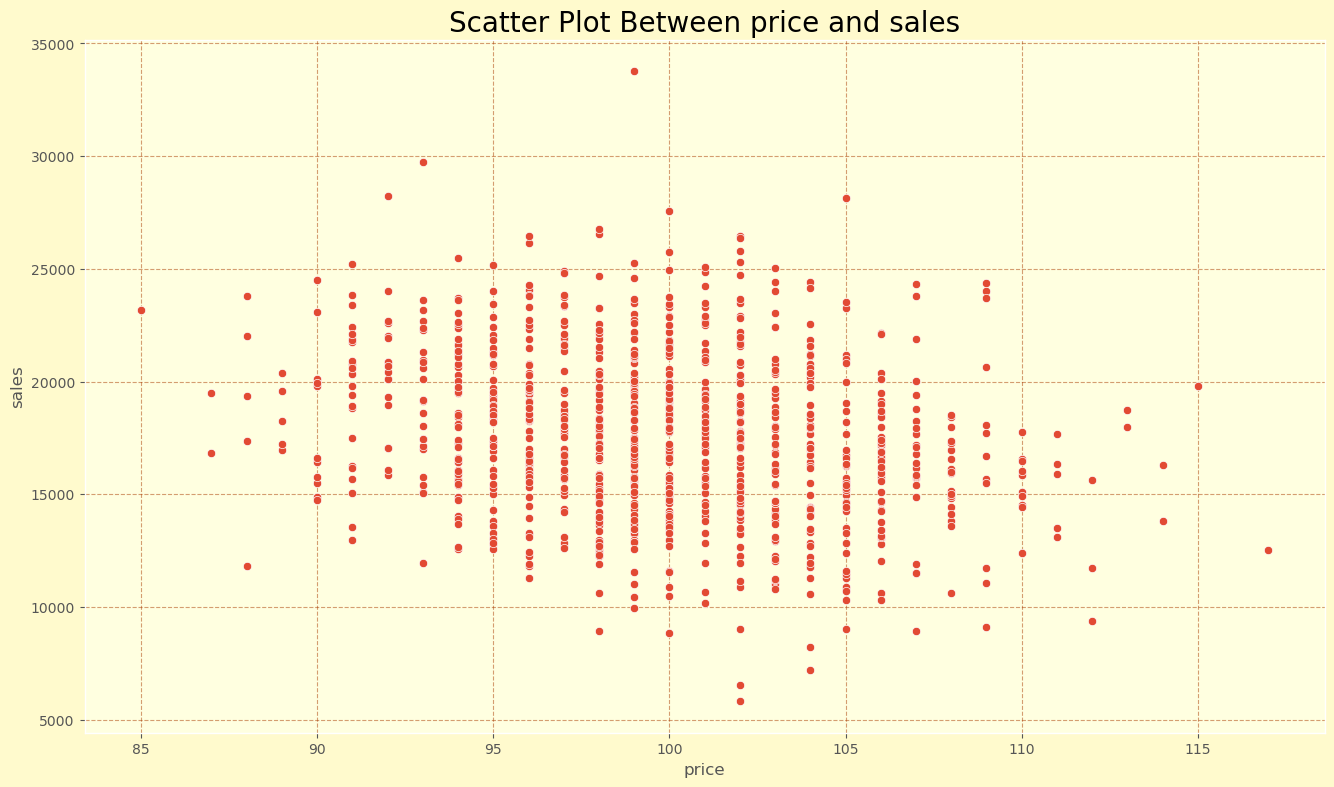

In [14]:
#scatter plot 
for feature in features:
    plt.figure()
    g = sns.scatterplot(x=feature, y='sales', data=df)
    g.set_title(f'Scatter Plot Between {feature} and sales',fontsize=20)
    
  
    plt.savefig(f'./chart/Scatter Plot Between {feature} and sales.jpg',format='jpeg',
                   dpi=300,
                   bbox_inches='tight')

<Figure size 1600x900 with 0 Axes>

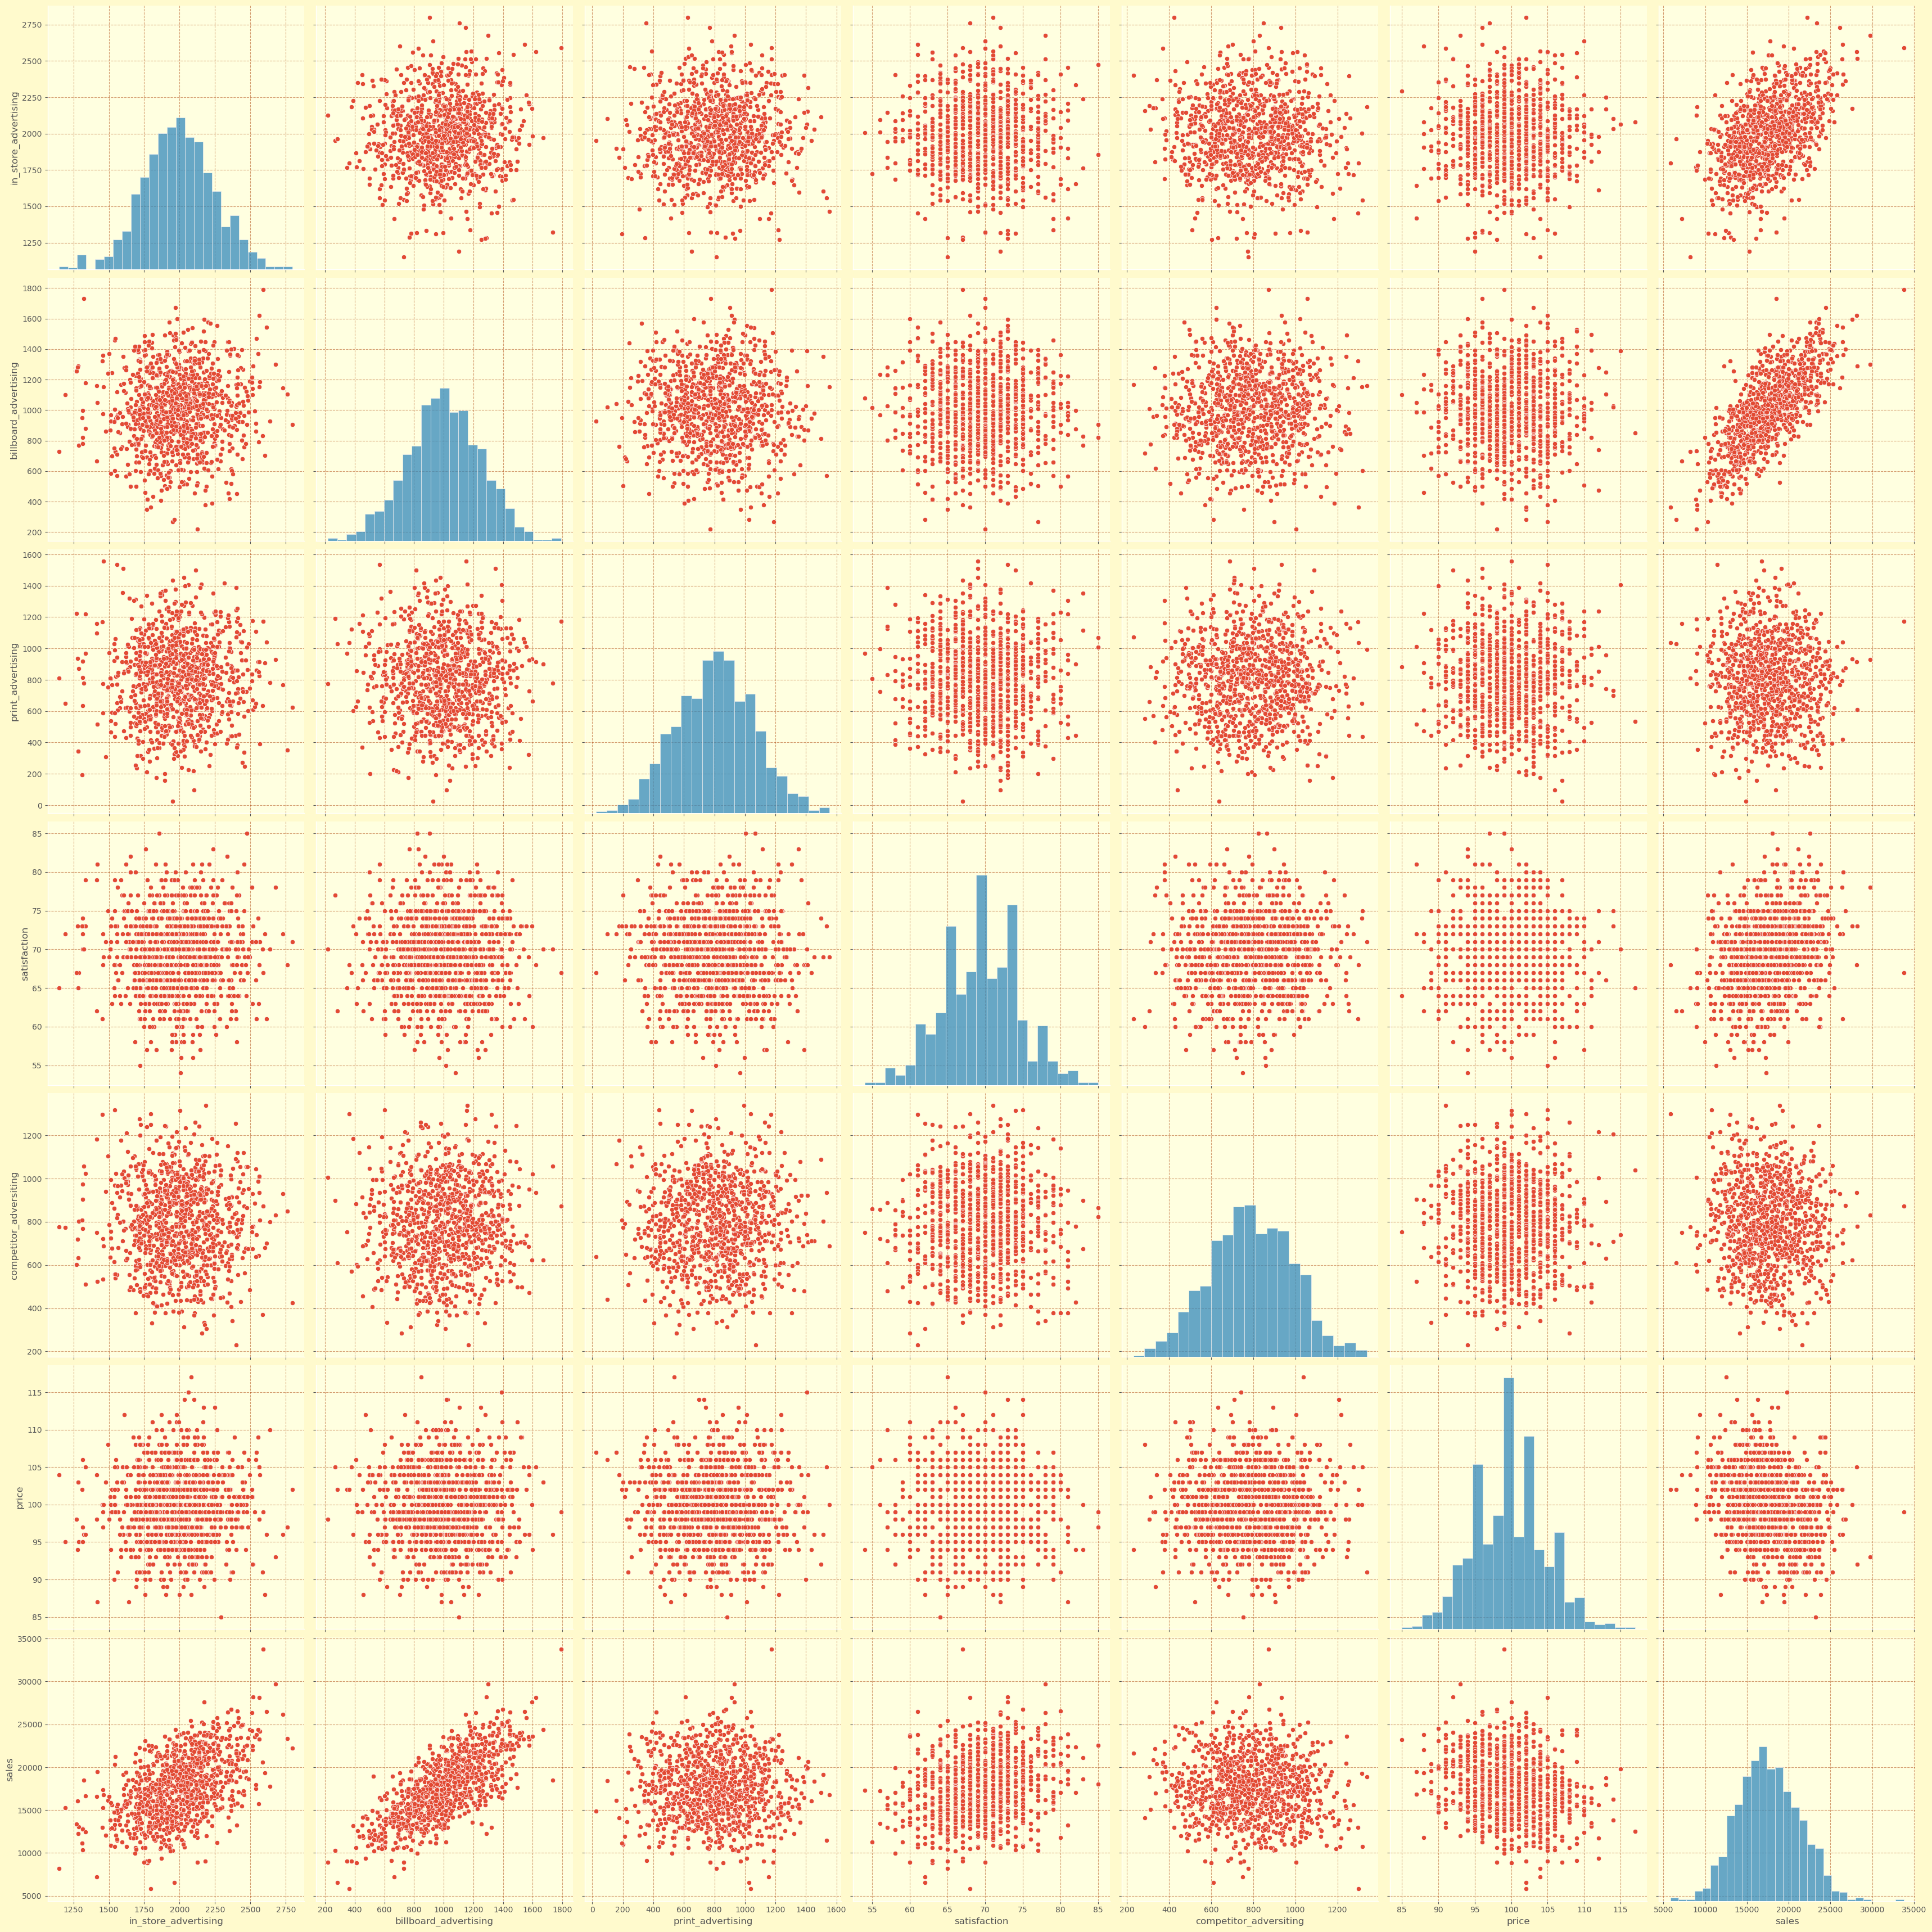

In [15]:
# pair plot
plt.figure()
g = sns.pairplot(df, height=5)
plt.show()

g.savefig(f'./chart/pairplot.jpg',format='jpeg',
           dpi=300,
           bbox_inches='tight')


**Insights:** 'in_store_advertising' and 'billboard_advertising' have somwehat linear relationship with 'sales

## 2.4 Correlation Matrix 

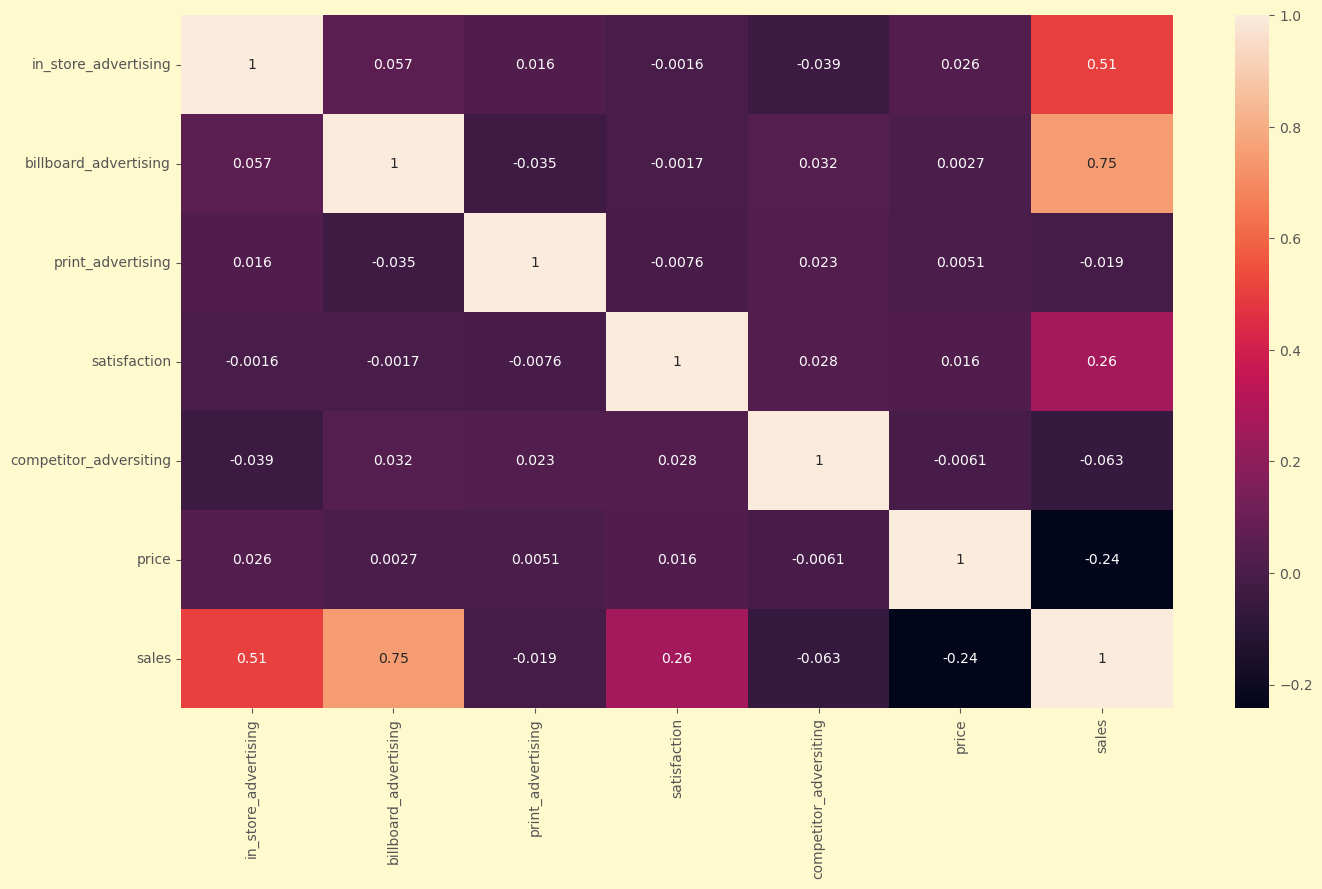

In [16]:
#correlation matrix
corrmat = df.corr()

g = sns.heatmap(corrmat, annot=True)


g.get_figure().savefig(f'./chart/correlation_matrix.jpg',format='jpeg',
                       dpi=300,
                       bbox_inches='tight')

**Insights: \
a: No clear correlation between dependent variables \
b: Strong correlarion with 'sales': 'in_store_advertising' & 'billboard_advertising';  Medium correlarion with 'sales': 'satisfaction' & 'price'**


## 2.5 Probability plot for all independent variables

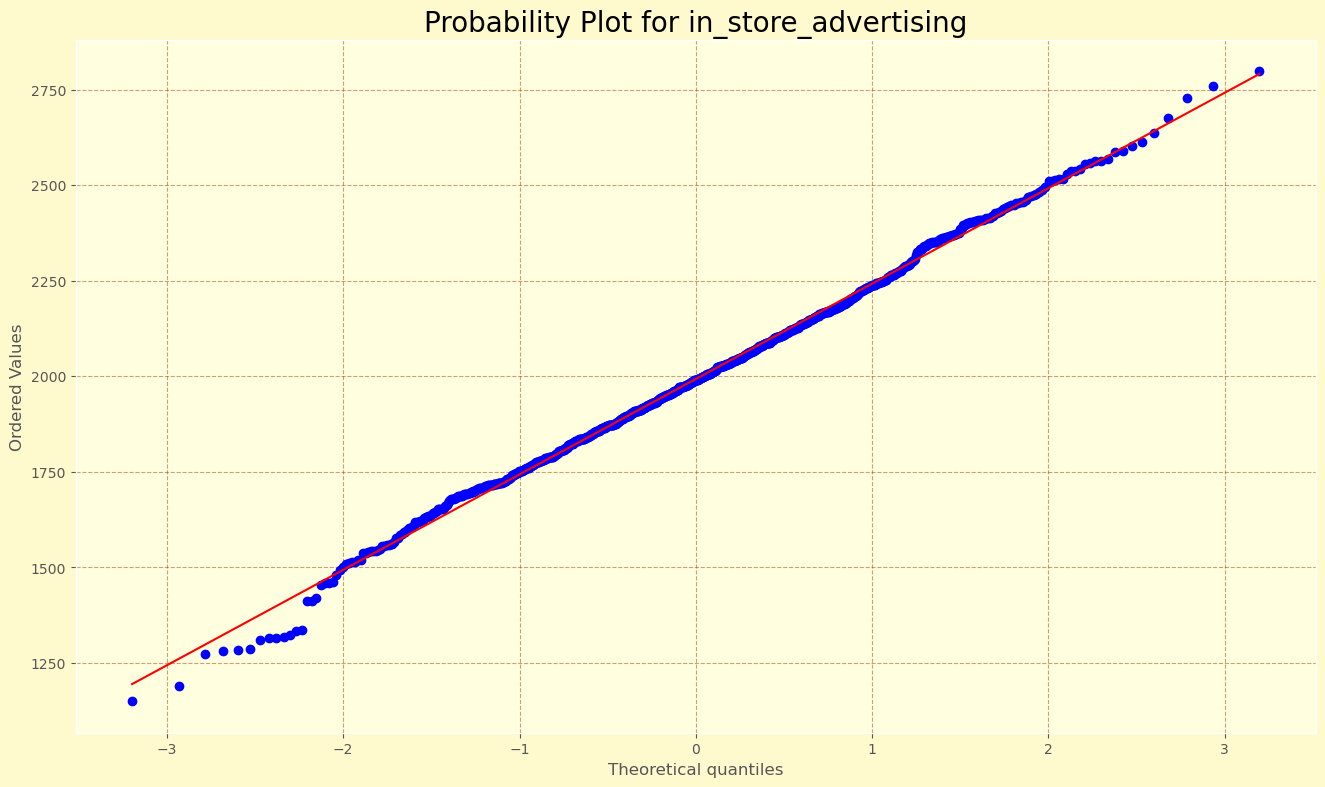

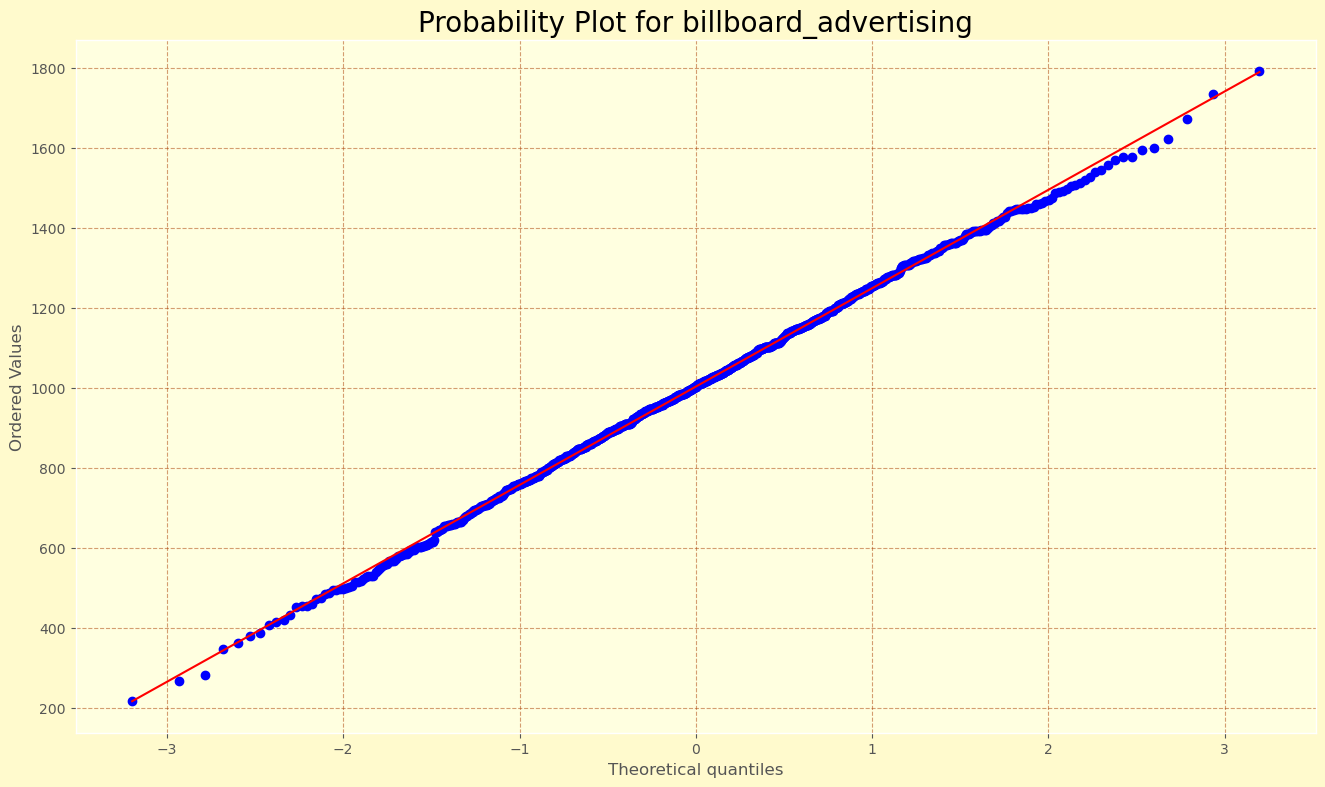

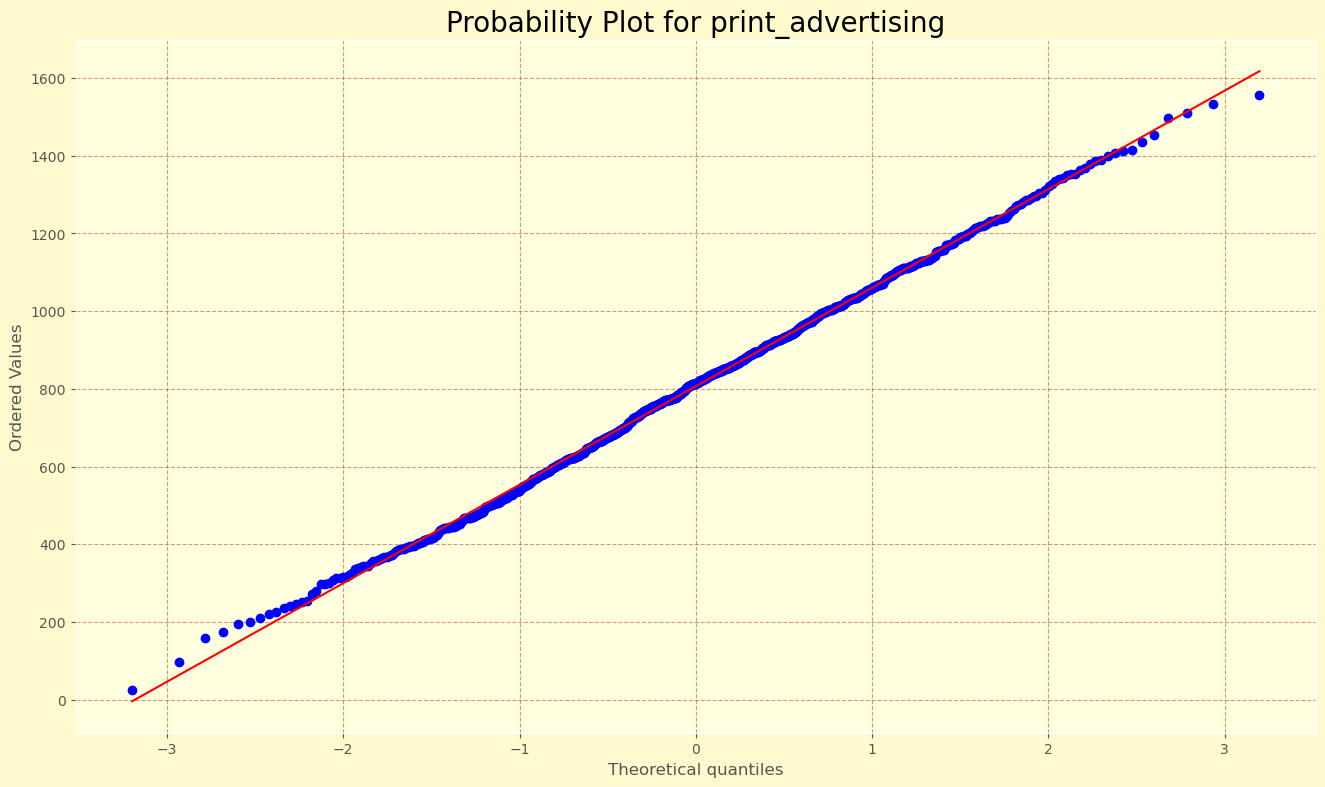

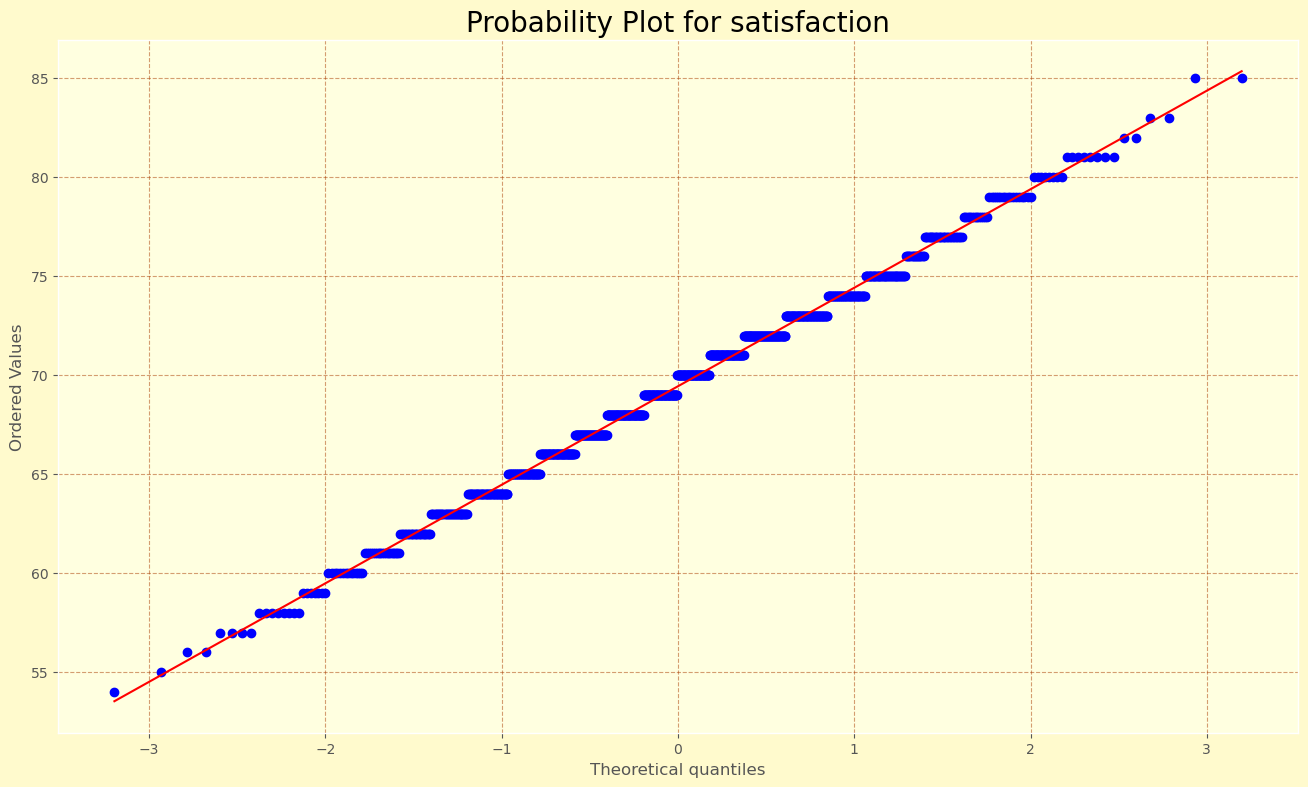

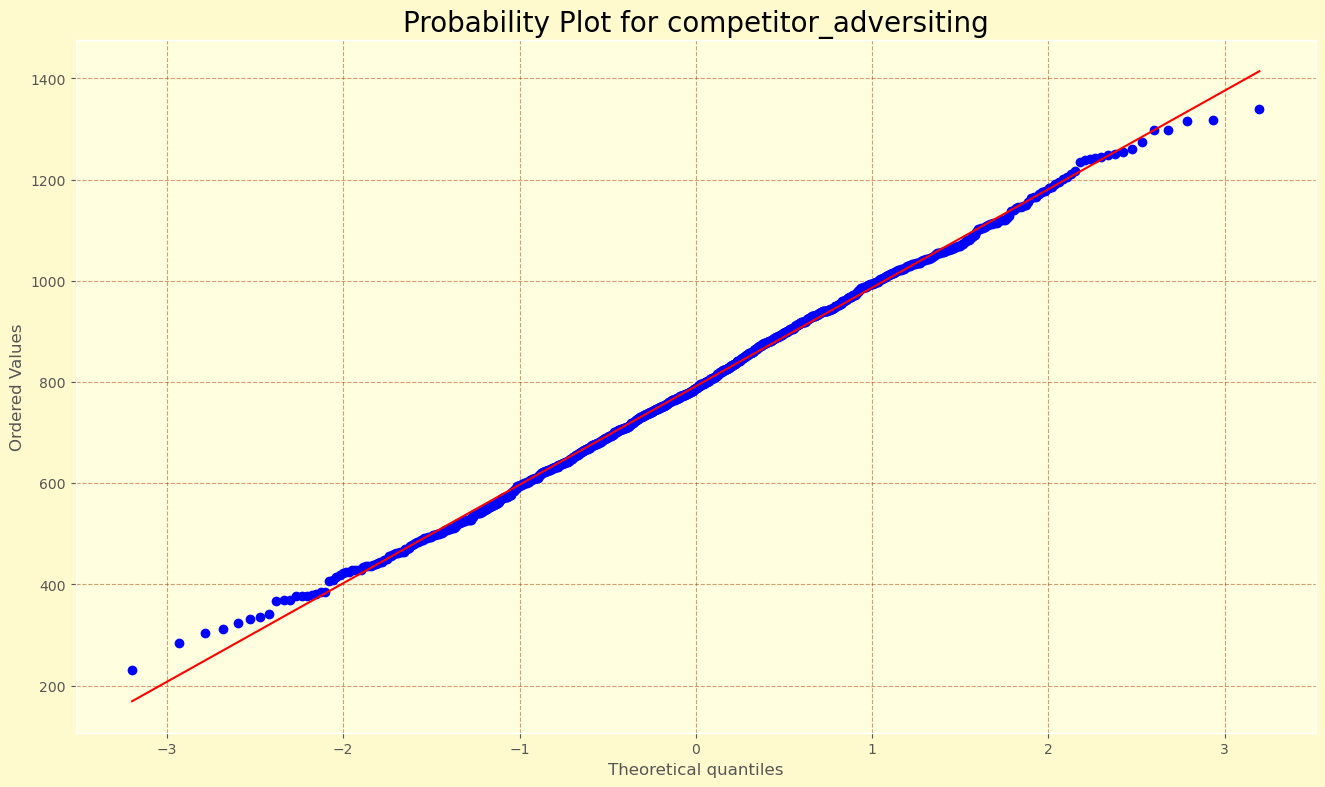

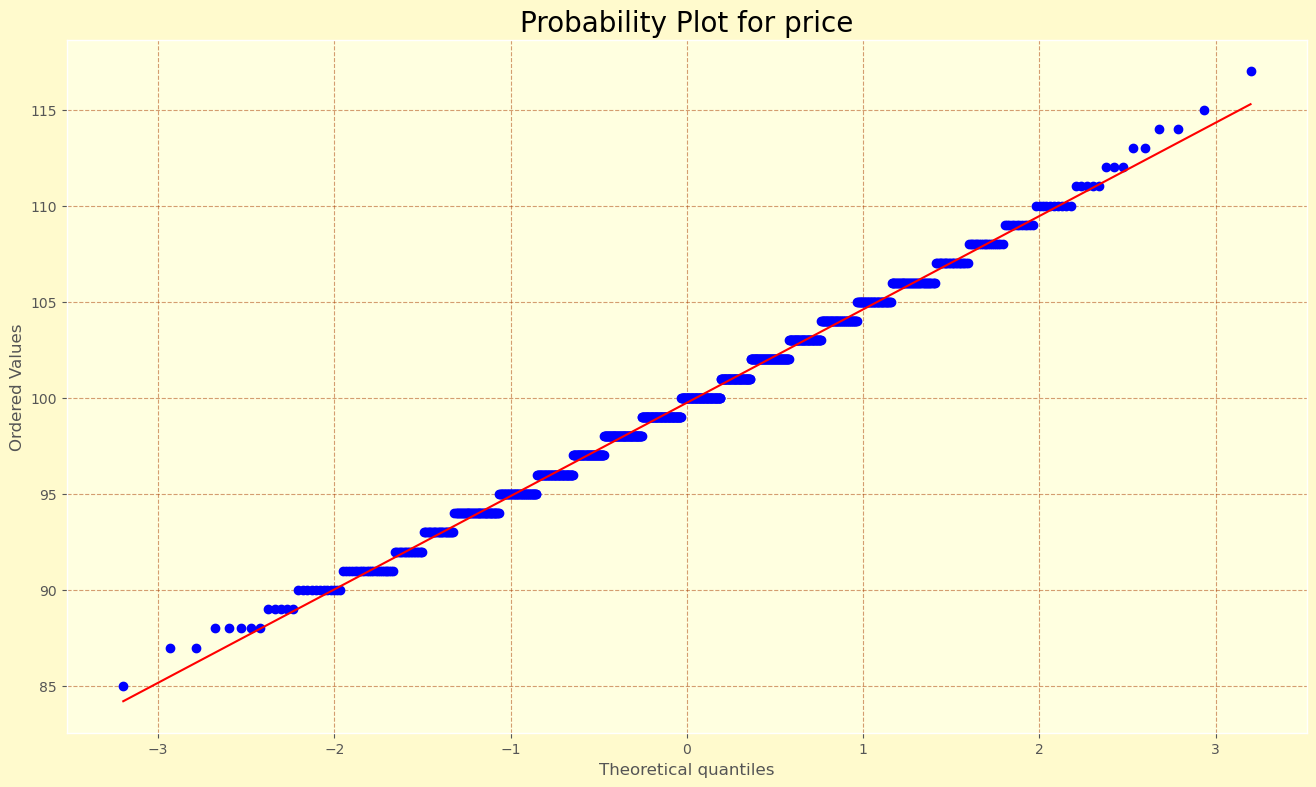

In [17]:
#prob plot 
for feature in features:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    res = stats.probplot(df[feature], plot=ax)
    ax.set_title(f'Probability Plot for {feature}',fontsize=20)

# 3. Train Test Split

In [18]:
columns = ['in_store_advertising', 'billboard_advertising', 'print_advertising',
           'satisfaction', 'competitor_adversiting', 'price']

In [19]:
x_train,x_test,y_train,y_test = train_test_split(df[features], df['sales'], 
                                                test_size = 0.25,random_state=42)

# Reset Index
for dataset in [x_train,x_test,y_train,y_test]:
    dataset.reset_index(drop=True,inplace=True)

# 4. Build parametric models

## 4.1 Basic linear regression

In [20]:
# Build basic linear regression model
x_train_lr1 = sm.add_constant(x_train)
x_test_lr1 = sm.add_constant(x_test)

lr1 = sm.OLS(y_train,x_train_lr1)
lr1 = lr1.fit()
print ("\n \n",lr1.summary())


 
                             OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1485.
Date:                Sun, 28 May 2023   Prob (F-statistic):               0.00
Time:                        12:00:26   Log-Likelihood:                -6269.3
No. Observations:                 750   AIC:                         1.255e+04
Df Residuals:                     743   BIC:                         1.258e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   

**Insights:** Intercept and 'print_advertising' are insignificant. "If the intercept is not significant you usually would not want to remove it from the model because by doing this you are creating a model that says that the response function must be zero when the predictors are all zero."(https://support.sas.com/kb/23/136.html)

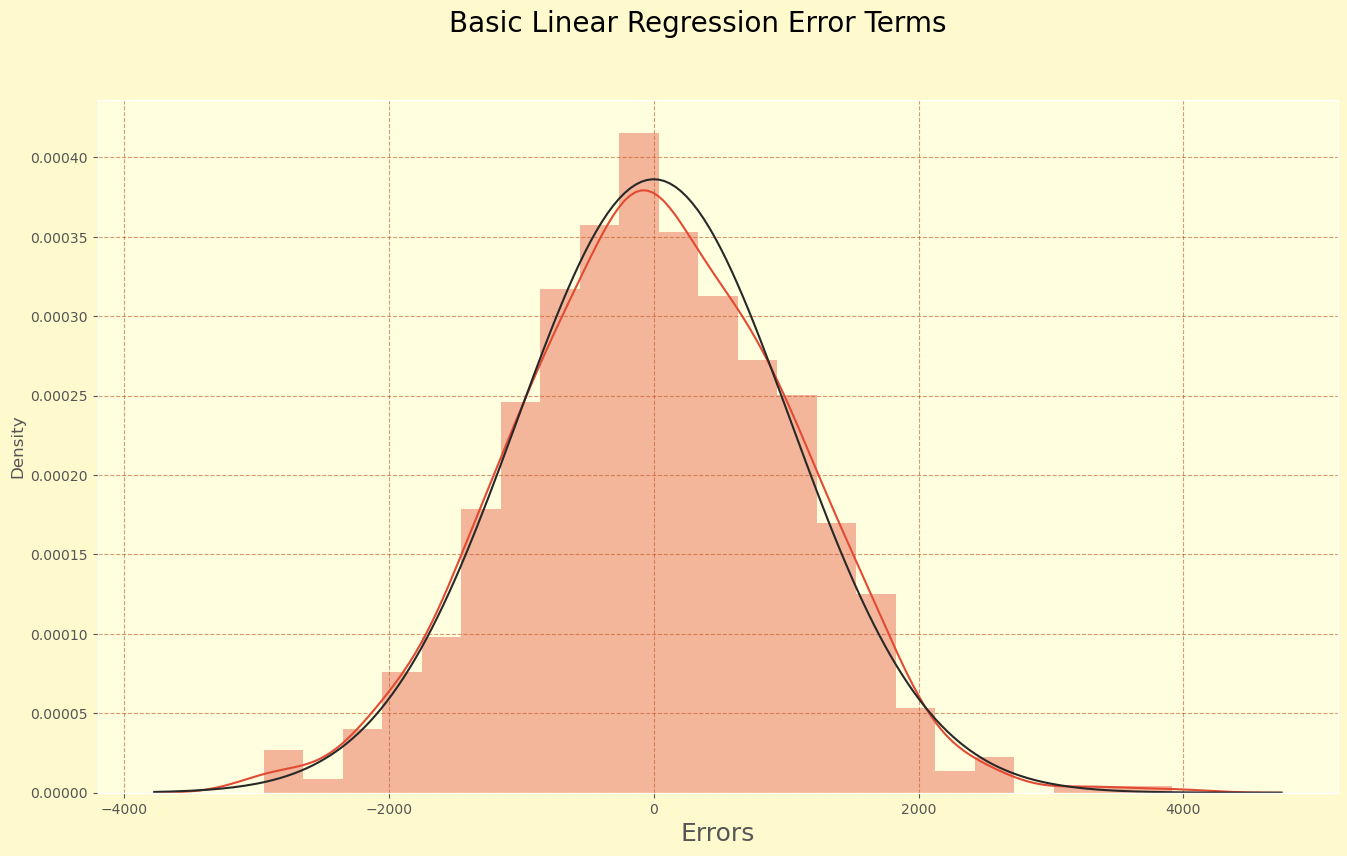

In [21]:
# Plot the histogram of the error terms
y_train_pred_lr1 = lr1.predict(x_train_lr1)
error1 = y_train-y_train_pred_lr1

fig = plt.figure()
sns.distplot(error1, fit=norm)
fig.suptitle('Basic Linear Regression Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)    
plt.show()

fig.savefig(f'./chart/Basic Linear Regression Error Terms.jpg',format='jpeg',
           dpi=300,
           bbox_inches='tight')

**Insights:** Residuals are normally distributed. Hence the assumption for linear regression is valid.

In [22]:
# Check multi-collinearity
print ("\033[1mVariance Inflation Factor\033[0m(Normally VIF <= 4 suggests no multi-collinearity):")
cnames = x_train.columns
for i in np.arange(0,len(cnames)):
    xvars = list(cnames)
    yvar = xvars.pop(i)
    lr = sm.OLS(x_train[yvar],sm.add_constant(x_train[xvars]))
    res = lr.fit()
    vif = 1/(1-res.rsquared)
    print(f'{yvar}: \033[1m{vif:.4f}\033[0m')

Variance Inflation Factor(Normally VIF <= 4 suggests no multi-collinearity):
in_store_advertising: 1.0164
billboard_advertising: 1.0179
print_advertising: 1.0059
satisfaction: 1.0036
competitor_adversiting: 1.0148
price: 1.0009


In [23]:
# Check model performance on test dataset
y_pred_lr1 = lr1.predict(x_test_lr1)
mse_lr1 = mean_squared_error(y_test, y_pred_lr1)
r2_lr1 = r2_score(y_test, y_pred_lr1)
print(f"mse for basic linear regression on test data is: \033[1m{mse_lr1:.4f}\033[0m")
print(f"r2 for basic linear regression on test data is: \033[1m{r2_lr1:.4f}\033[0m")

mse for basic linear regression on test data is: 1102950.3898
r2 for basic linear regression on test data is: 0.9089


## 4.2 Linear regression with interactions & Backward Elimination

In [24]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
x_train_interaction = poly.fit_transform(x_train)

# Replace get_feature_names() with get_feature_names_out() if error orrurs
x_train_interaction = pd.DataFrame(x_train_interaction, columns = [x.replace(' ',' X ') for x in poly.get_feature_names(x_train.columns)])

x_test_interaction = poly.transform(x_test)
x_test_interaction = pd.DataFrame(x_test_interaction, columns = [x.replace(' ',' X ') for x in poly.get_feature_names(x_test.columns)])

In [25]:
display(x_train_interaction.head(1))
display(x_test_interaction.head(1))

in_store_advertising  billboard_advertising  print_advertising  satisfaction  competitor_adversiting   price  in_store_advertising X billboard_advertising  in_store_advertising X print_advertising  in_store_advertising X satisfaction  in_store_advertising X competitor_adversiting  in_store_advertising X price  billboard_advertising X print_advertising  billboard_advertising X satisfaction  billboard_advertising X competitor_adversiting  billboard_advertising X price  print_advertising X satisfaction  print_advertising X competitor_adversiting  print_advertising X price  satisfaction X competitor_adversiting  satisfaction X price  competitor_adversiting X price
0             1656.0000              1074.0000           693.0000       69.0000                931.0000 93.0000                                  1778544.0000                              1147608.0000                          114264.0000                                   1541736.0000                   154008.0000                                744282.0000                            74106.0000                                     999894.0000                     99882.0000                        47817.0000                                 645183.0000                 64449.0000                             64239.0000             6417.0000                      86583.0000

in_store_advertising  billboard_advertising  print_advertising  satisfaction  competitor_adversiting    price  in_store_advertising X billboard_advertising  in_store_advertising X print_advertising  in_store_advertising X satisfaction  in_store_advertising X competitor_adversiting  in_store_advertising X price  billboard_advertising X print_advertising  billboard_advertising X satisfaction  billboard_advertising X competitor_adversiting  billboard_advertising X price  print_advertising X satisfaction  print_advertising X competitor_adversiting  print_advertising X price  satisfaction X competitor_adversiting  satisfaction X price  competitor_adversiting X price
0             1964.0000              1192.0000           325.0000       62.0000               1113.0000 100.0000                                  2341088.0000                               638300.0000                          121768.0000                                   2185932.0000                   196400.0000                                387400.0000                            73904.0000                                    1326696.0000                    119200.0000                        20150.0000                                 361725.0000                 32500.0000                             69006.0000             6200.0000                     111300.0000

In [26]:
# Build linear regression model with interation features
x_train_lr2 = sm.add_constant(x_train_interaction)
x_test_lr2 = sm.add_constant(x_test_interaction)

lr2 = sm.OLS(y_train,x_train_lr2)
lr2 = lr2.fit()
print("\n \n",lr2.summary())


 
                             OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     460.8
Date:                Sun, 28 May 2023   Prob (F-statistic):               0.00
Time:                        12:00:27   Log-Likelihood:                -6233.6
No. Observations:                 750   AIC:                         1.251e+04
Df Residuals:                     728   BIC:                         1.261e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

### 4.2.1 Backward Elimination to select features

In [27]:
cols = list(x_train_interaction.columns)
while (len(cols)>0):
    data = x_train_interaction[cols]
    data = sm.add_constant(data)
    lr2 = sm.OLS(y_train,data).fit()
    
    # Get p-values from model summary
    p_list = pd.Series(lr2.pvalues.values[1:],index = cols)      
    pmax = max(p_list)
    feature_with_p_max = p_list.idxmax()
    # Kick out insignificant feature
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(f'Features selected: {selected_features_BE}')
print("\n \n",lr2.summary())

Features selected: ['in_store_advertising', 'print_advertising', 'satisfaction', 'competitor_adversiting', 'price', 'in_store_advertising X billboard_advertising', 'billboard_advertising X satisfaction', 'print_advertising X price']

 
                             OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     1219.
Date:                Sun, 28 May 2023   Prob (F-statistic):               0.00
Time:                        12:00:27   Log-Likelihood:                -6237.1
No. Observations:                 750   AIC:                         1.249e+04
Df Residuals:                     741   BIC:                         1.253e+04
Df Model:                           8                                         
Covariance Type:            nonrobust               

**Insights:** The F-Statistics value of 1219 (which is greater than 1) and the p-value of '~0.00' states that the overall model is significant

The equation of best fitted surface based on model lr2:\
sales = 16530.4608 + (**in_store_advertising** × 2.4558) - (**print_advertising** × 6.6244) + (**satisfaction** × 168.6509) − (**competitor_adversiting** × 1.5340) - (**price** × 253.7026) + (**in_store_advertising X billboard_advertising** × 0.0043) + (**billboard_advertising X satisfaction** × 0.0333) + (print_advertising X price × 0.0666)

Interpretation of Coefficients:\
in_store_advertising: A coefficient value of '2.455' indicated that a unit increase in in_store_advertising, increases the sales by 2.455 units.

In [28]:
# Prepare new data with selected features
x_train_lr2 = sm.add_constant(x_train_interaction[selected_features_BE])
x_test_lr2 = sm.add_constant(x_test_interaction[selected_features_BE])

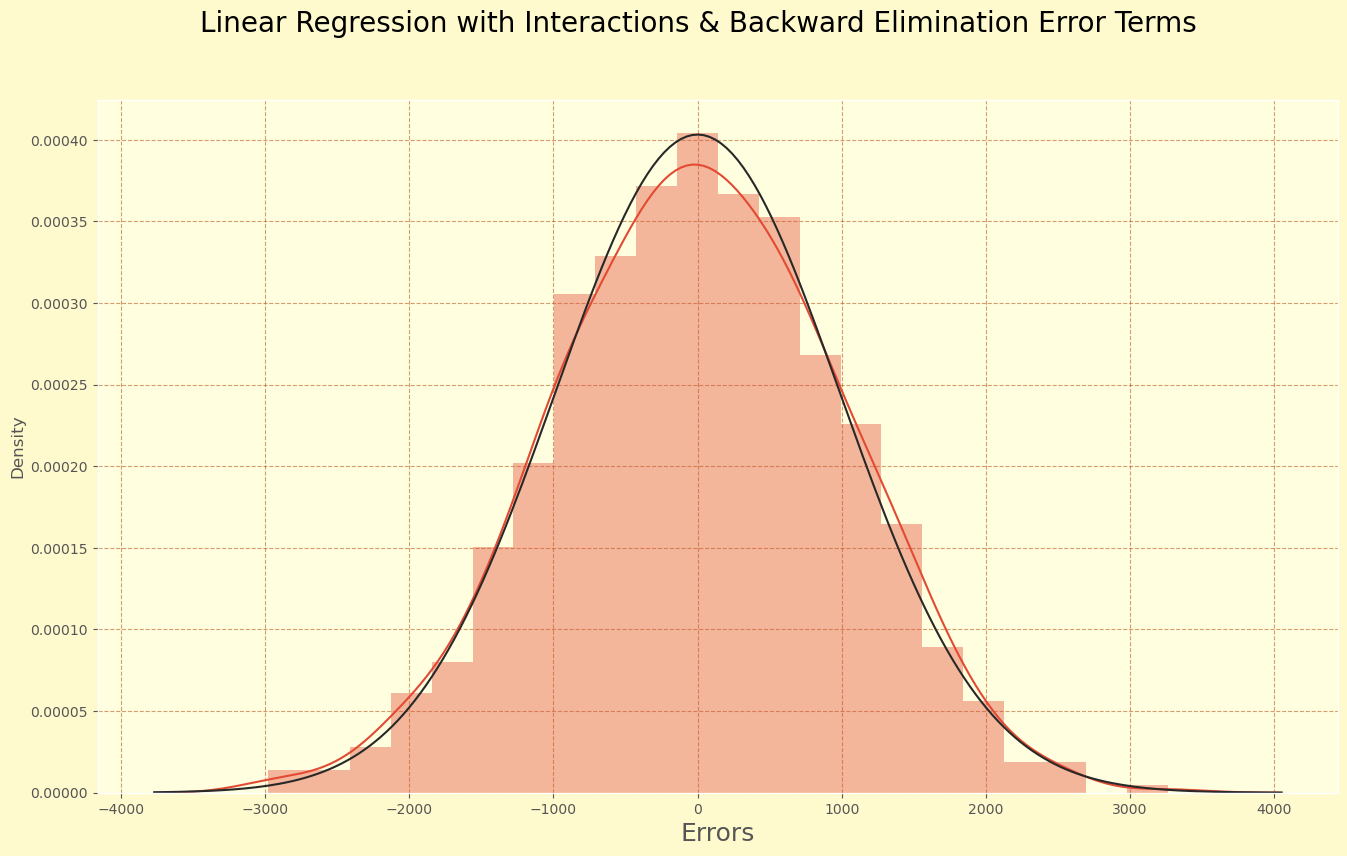

In [29]:
# Plot the histogram of the error terms
y_train_pred_lr2 = lr2.predict(x_train_lr2)
error2 = y_train-y_train_pred_lr2

fig = plt.figure()
sns.distplot(error2, fit=norm)
fig.suptitle('Linear Regression with Interactions & Backward Elimination Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)    
plt.show()

fig.savefig(f'./chart/Linear Regression with Interactions & Backward Elimination Error Terms.jpg',format='jpeg',
           dpi=300,
           bbox_inches='tight')

In [30]:
# Check model performance on test dataset
y_pred_lr2 = lr2.predict(x_test_lr2)
mse_lr2 = mean_squared_error(y_test, y_pred_lr2)
r2_lr2 = r2_score(y_test, y_pred_lr2)
print(f"mse for linear regression with interactions & backward elimination on test data is: \033[1m{mse_lr2:.4f}\033[0m")
print(f"r2 for linear regression with interactions & backward elimination on test data is: \033[1m{r2_lr2:.4f}\033[0m")

mse for linear regression with interactions & backward elimination on test data is: 1017226.9249
r2 for linear regression with interactions & backward elimination on test data is: 0.9160


## 4.3 Linear regression with interactions & Lasso

### 4.3.1 Find Optimal Alpha for Lasso

In [31]:
alpharange = np.logspace(-10,1,1000,base=10)
alpharange.shape

(1000,)

In [32]:
lr3 = LassoCV(alphas=alpharange, cv=5).fit(x_train_interaction,y_train)

In [33]:
print(f'Optimal alpha for LASSO is \033[1m{lr3.alpha_:.6f}\033[0m')

Optimal alpha for LASSO is 3.115254


In [34]:
print ("\033[1mLasso Regression intercept value:\033[0m",lr3.intercept_)
print ("\n\033[1mLasso Regression coefficient values:\033[0m")
for i in range(len(x_train_interaction.columns)):
    print (x_train_interaction.columns[i],": ",lr3.coef_[i])

Lasso Regression intercept value: 4105.397866045316

Lasso Regression coefficient values:
in_store_advertising :  5.5841021932456805
billboard_advertising :  5.413269291738976
print_advertising :  -6.9714777172341895
satisfaction :  199.9576098817163
competitor_adversiting :  -1.5491713867813417
price :  -141.27192949728246
in_store_advertising X billboard_advertising :  0.004434643815132759
in_store_advertising X print_advertising :  0.00018405152618660865
in_store_advertising X satisfaction :  -0.028695889020867577
in_store_advertising X competitor_adversiting :  0.0003359188863542688
in_store_advertising X price :  -0.016872197056641402
billboard_advertising X print_advertising :  -0.0008051195272374815
billboard_advertising X satisfaction :  0.04589938197014534
billboard_advertising X competitor_adversiting :  6.172070571319158e-05
billboard_advertising X price :  -0.05909167131219388
print_advertising X satisfaction :  0.02821107123795107
print_advertising X competitor_adversiting

In [35]:
# Check model performance on test dataset
y_pred_lr3 = lr3.predict(x_test_interaction)

mse_lr3 = mean_squared_error(y_test, y_pred_lr3)
r2_lr3 = r2_score(y_test, y_pred_lr3)
print(f"mse for LASSO on test data is: \033[1m{mse_lr3:.4f}\033[0m")
print(f"r2 for LASSO on test data is: \033[1m{r2_lr3:.4f}\033[0m")

mse for LASSO on test data is: 1038360.0652
r2 for LASSO on test data is: 0.9142
